<a href="https://colab.research.google.com/github/Noonanav/phage_host_set_transformers/blob/main/set_transformer_modeling_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Transformer for Strain-Phage Interaction Prediction

## Block 1: Import Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional
import warnings
from tqdm import tqdm
import time
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import seaborn as sns
import pickle
import os
from pathlib import Path
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Block 2: Data Loading and Preprocessing
Description: This block handles the loading of strain and phage embeddings, splitting the interactions into train and test sets, creating datasets and data loaders, and managing variable-length inputs.

## Hyperparameters and Architectural Decisions
### `filter_interactions_by_strain` function:
- `test_size`: Proportion of strains used for testing.
  - Current value: 0.2
  - Possible values to try: 0.1, 0.15, 0.25, 0.3

### `create_data_loaders` function:  
- `batch_size`: Number of samples per batch during training and testing.
  - Current value: 1
  - Possible values to try: 2, 4, 8, 16, 32
- `num_workers`: Number of parallel workers for data loading.
  - Current value: 0
  - Possible values to try: 2, 4, 8

In [ ]:
from pathlib import Path

def load_embeddings_with_ids(embedding_dir: str) -> Dict[str, Tuple[np.ndarray, List[str]]]:
    """
    Load all embeddings from a directory (.npy files).
    Each file should contain a dictionary of embeddings.
    Returns a dictionary mapping strain/phage IDs to:
        - a numpy array of shape [num_genes, 1280]
        - a list of gene IDs corresponding to the array rows
    """
    embedding_dir = Path(embedding_dir)
    embeddings = {}

    for file_path in embedding_dir.glob('*.npy'):
        identifier = file_path.stem  # filename without extension
        print('Parsing: ', identifier)

        # Load the dictionary format embeddings
        embeddings_dict = np.load(file_path, allow_pickle=True).item()

        # Extract genes and their IDs
        gene_ids = list(embeddings_dict.keys())
        embedding_list = [embeddings_dict[gene_id] for gene_id in gene_ids]
        embeddings_array = np.stack(embedding_list)

        # Store both the array and the gene IDs
        embeddings[identifier] = (embeddings_array, gene_ids)

    print(f"Loaded {len(embeddings)} embeddings from {embedding_dir}")
    return embeddings

def filter_interactions_by_strain(interactions_df: pd.DataFrame,
                                  random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split interactions into train/test by strain.
    """
    unique_strains = interactions_df['strain'].unique()
    train_strains, test_strains = train_test_split(
        unique_strains,
        test_size=0.2,
        random_state=random_state
    )

    train_df = interactions_df[interactions_df['strain'].isin(train_strains)]
    test_df = interactions_df[interactions_df['strain'].isin(test_strains)]

    print(f"Train set: {len(train_df)} interactions, {len(train_strains)} strains")
    print(f"Test set:  {len(test_df)} interactions, {len(test_strains)} strains")
    return train_df, test_df

class StrainPhageDataset(Dataset):
    def __init__(self,
                 interactions_df: pd.DataFrame,
                 strain_embeddings: Dict[str, Tuple[np.ndarray, List[str]]],
                 phage_embeddings: Dict[str, Tuple[np.ndarray, List[str]]]):
        """
        Dataset for strain-phage interactions.
        interactions_df has columns: ['strain', 'phage', 'interaction'].
        """
        self.interactions = interactions_df.reset_index(drop=True)
        self.strain_embeddings = strain_embeddings
        self.phage_embeddings = phage_embeddings

        # Check for missing embeddings
        missing_strains = set(self.interactions['strain']) - set(strain_embeddings.keys())
        missing_phages = set(self.interactions['phage']) - set(phage_embeddings.keys())

        if missing_strains or missing_phages:
            raise ValueError(
                f"Missing embeddings for {len(missing_strains)} strains "
                f"and {len(missing_phages)} phages."
            )

    def __len__(self):
        return len(self.interactions)

    def __getitem__(self, idx):
        row = self.interactions.iloc[idx]
        # Get the array part of the tuple (idx 0)
        strain_emb = torch.tensor(
            self.strain_embeddings[row['strain']][0], dtype=torch.float32
        )  # shape [n_s, 1280]
        phage_emb = torch.tensor(
            self.phage_embeddings[row['phage']][0], dtype=torch.float32
        )   # shape [n_p, 1280]
        label = torch.tensor(row['interaction'], dtype=torch.float32)
        return strain_emb, phage_emb, label, row['strain'], row['phage']

def collate_variable_sets(batch):
    """
    Args:
      batch: list of (strain_emb, phage_emb, label)
        - strain_emb: shape [S, emb_dim]
        - phage_emb:  shape [P, emb_dim]
        - label: single scalar or shape (1,)

    Returns:
      strain_padded: (B, S_max, emb_dim)
      phage_padded : (B, P_max, emb_dim)
      strain_mask  : (B, S_max) boolean
      phage_mask   : (B, P_max) boolean
      label_batch  : (B, 1)
    """
    strains, phages, labels = zip(*batch)

    # 1) Find max set sizes
    max_strain_len = max(s.shape[0] for s in strains)
    max_phage_len  = max(p.shape[0] for p in phages)

    # 2) Emb dim (assume consistent)
    emb_dim = strains[0].shape[1]
    batch_size = len(batch)

    # 3) Allocate zero-padded Tensors + boolean masks
    strain_padded = torch.zeros(batch_size, max_strain_len, emb_dim, dtype=torch.float32)
    phage_padded  = torch.zeros(batch_size, max_phage_len,  emb_dim, dtype=torch.float32)

    strain_mask   = torch.zeros(batch_size, max_strain_len, dtype=torch.bool)
    phage_mask    = torch.zeros(batch_size, max_phage_len,  dtype=torch.bool)

    label_batch   = torch.zeros(batch_size, 1, dtype=torch.float32)

    # 4) Copy each sample’s data into padded Tensors
    for i, (s_emb, p_emb, label) in enumerate(batch):
        s_len = s_emb.shape[0]
        p_len = p_emb.shape[0]

        strain_padded[i, :s_len, :] = s_emb
        phage_padded[i, :p_len, :]  = p_emb
        strain_mask[i, :s_len]      = True
        phage_mask[i,  :p_len]      = True

        label_batch[i, 0] = float(label)

    return strain_padded, phage_padded, strain_mask, phage_mask, label_batch

def create_data_loaders(train_df: Optional[pd.DataFrame],
                            test_df: pd.DataFrame,
                            strain_embeddings: Dict[str, np.ndarray],
                            phage_embeddings: Dict[str, np.ndarray],
                            batch_size: int = 1) -> Tuple[DataLoader, DataLoader]:

        train_loader = None # Initialize train_loader as None
        if train_df is not None and not train_df.empty: # add a check before proceeding:
            train_dataset = StrainPhageDataset(train_df, strain_embeddings, phage_embeddings)
            train_loader = DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=0,
                pin_memory=True,
                collate_fn=collate_variable_sets
            )

        test_dataset  = StrainPhageDataset(test_df, strain_embeddings, phage_embeddings)
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
            collate_fn=collate_variable_sets
        )

        return train_loader, test_loader # now, it can return None for `train_loader`

## Inspect Embeddings

In [ ]:
def inspect_embedding_structure(embedding_dir: str):
    """
    Load the first embedding file and inspect its structure
    to understand how gene IDs are stored.
    """
    embedding_dir = Path(embedding_dir)

    # Get the first file only
    file_paths = list(embedding_dir.glob('*.npy'))
    if not file_paths:
        print(f"No .npy files found in {embedding_dir}")
        return

    first_file = file_paths[0]
    identifier = first_file.stem  # filename without extension
    print(f'Inspecting file: {first_file}')

    # Load the file
    embedding = np.load(first_file, allow_pickle=True)

    # Print basic info
    print(f"\nEmbedding identifier: {identifier}")
    print(f"Embedding type: {type(embedding)}")
    print(f"Embedding shape: {embedding.shape}")

    # If it's a numpy array, show a sample
    if isinstance(embedding, np.ndarray):
        if embedding.ndim == 2:
            print("\nSample (first 3 rows, first 5 columns):")
            print(embedding[:3, :5])
        else:
            print("\nUnexpected array dimensions. Full structure:")
            print(embedding)

    # If it's a dictionary or object array, examine structure
    elif isinstance(embedding, (dict, np.ndarray)) and hasattr(embedding, 'item'):
        if hasattr(embedding.item(), 'keys'):
            print("\nEmbedding appears to be a dictionary-like object")
            print("Keys:", embedding.item().keys())
            # Sample the first item
            first_key = list(embedding.item().keys())[0]
            print(f"\nSample for key '{first_key}':")
            print(embedding.item()[first_key][:5] if isinstance(embedding.item()[first_key], (list, np.ndarray)) else embedding.item()[first_key])

    # Check any attributes
    if hasattr(embedding, '__dict__'):
        print("\nAttributes:")
        for attr in dir(embedding):
            if not attr.startswith('_'):
                print(f"  {attr}")

    return embedding  # Return for further inspection if needed

# Call the function
sample_embedding = inspect_embedding_structure('/content/drive/MyDrive/Arkin/set_transformer_data/embedding_sets/strains')

Inspecting file: /content/drive/MyDrive/Arkin/set_transformer_data/embedding_sets/strains/ECOR17.npy

Embedding identifier: ECOR17
Embedding type: <class 'numpy.ndarray'>
Embedding shape: (49, 1280)

Sample (first 3 rows, first 5 columns):
[[ 2.3735325  -4.012263   -1.0772631  -1.048405   -2.309111  ]
 [ 0.8825483  -3.5288646  -1.7427737  -0.44220394  1.2755007 ]
 [ 0.3647181  -5.709437   -2.2260387  -0.1618739  -4.900755  ]]


# Block 3: Set Transformer Blocks
Description: This block implements the core components of the Set Transformer architecture, including the Multi-head Attention Block (MAB), Induced Set Attention Block (ISAB), and Pooling by Multihead Attention (PMA).

## Hyperparameters and Architectural Decisions
### `MAB` class:
- `num_heads`: Number of attention heads in the multi-head attention mechanism.
  - Current value: Determined by the `num_heads` parameter passed to the `ISAB` and `PMA` classes
  - Possible values to try: 4, 8, 12, 16
- `ln`: Whether to apply layer normalization after the attention operation.
  - Current value: False
  - Possible values to try: True

### `ISAB` class:
- `num_inds`: Number of inducing points used to reduce computational complexity.
  - Current value: Determined by the `strain_inds` and `phage_inds` parameters in the `StrainPhageTransformer` class
    - For the strain encoder: `strain_inds=128`
    - For the phage encoder: `phage_inds=64`
  - Possible values to try: 32, 64, 96, 128
- `ln`: Whether to apply layer normalization.
  - Current value: False
  - Possible values to try: True

### `PMA` class:
- `num_heads`: Number of attention heads in the pooling mechanism.
  - Current value: Determined by the `num_heads` parameter passed to the `StrainPhageTransformer` class
  - Possible values to try: 4, 8, 12, 16  
- `num_seeds`: Number of output vectors after pooling.
  - Current value: 1
  - Possible values to try: 2, 4, 8
- `ln`: Whether to apply layer normalization.  
  - Current value: False
  - Possible values to try: True

In [ ]:
class MAB(nn.Module):
    """Multi-head Attention Block."""
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False, temperature=0.1):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.temperature = temperature  # Add this parameter
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)
        self.ln = nn.LayerNorm(dim_V) if ln else nn.Identity()

    def forward(self, Q, K, mask=None, return_attn=False):
        """
        Q: [B, n_q, d]
        K: [B, n_k, d]
        mask: [B, n_k] boolean (True = real, False = pad)
        """
        Q_ = self.fc_q(Q)
        K_ = self.fc_k(K)
        V_ = self.fc_v(K)

        B, n_q, _ = Q_.shape
        _, n_k, _ = K_.shape
        dim_split = self.dim_V // self.num_heads

        # reshape
        Q_ = Q_.view(B, n_q, self.num_heads, dim_split).transpose(1,2)  # [B,h,n_q,d_h]
        K_ = K_.view(B, n_k, self.num_heads, dim_split).transpose(1,2)
        V_ = V_.view(B, n_k, self.num_heads, dim_split).transpose(1,2)

        # compute attention logits with temperature scaling
        A = torch.matmul(Q_, K_.transpose(-2, -1)) / (np.sqrt(dim_split) * self.temperature)  # [B,h,n_q,n_k]

        # if we have a mask, apply it to A
        if mask is not None:
            # mask: [B, n_k], we need [B,h,n_q,n_k] for broadcast
            mask_expanded = mask.unsqueeze(1).unsqueeze(2)  # [B,1,1,n_k]
            # fill masked positions with -inf
            A = A.masked_fill(~mask_expanded, float('-inf'))

        A = torch.softmax(A, dim=-1)  # [B,h,n_q,n_k]

        # Weighted sum
        O = torch.matmul(A, V_)  # [B,h,n_q,d_h]
        O = O.transpose(1,2).contiguous().view(B, n_q, self.dim_V)
        O = self.ln(O + F.relu(self.fc_o(O)))

        if return_attn:
            return O, A
        else:
            return O

class ISAB(nn.Module):
    """
    Induced Set Attention Block.
    Reduces complexity by using M learned 'inducing' vectors.
    """
    def __init__(self, dim_in, dim_out, num_heads, num_inds, ln=False, temperature=0.1):
        super(ISAB, self).__init__()
        self.num_inds = num_inds
        self.I = nn.Parameter(torch.Tensor(1, num_inds, dim_out))
        nn.init.xavier_uniform_(self.I)

        self.mab1 = MAB(dim_out, dim_in, dim_out, num_heads, ln=ln, temperature=temperature)
        self.mab2 = MAB(dim_in, dim_out, dim_out, num_heads, ln=ln, temperature=temperature)

    def forward(self, X, mask=None):
        # Use self.mab1, not self.isab1:
        H = self.mab1(self.I.repeat(X.size(0),1,1), X, mask=mask)
        H = self.mab2(X, H)
        return H

class PMA(nn.Module):
    """
    Pooling by Multihead Attention to reduce a set to num_seeds outputs.
    By default, set num_seeds=1 to get a single vector.
    """
    def __init__(self, dim, num_heads, num_seeds=1, ln=False, temperature=0.1):
        super(PMA, self).__init__()
        self.num_seeds = num_seeds
        self.S = nn.Parameter(torch.Tensor(1, num_seeds, dim))
        nn.init.xavier_uniform_(self.S)
        self.mab = MAB(dim, dim, dim, num_heads, ln=ln, temperature=temperature)

    def forward(self, X, mask=None):
        B = X.size(0)
        S = self.S.repeat(B,1,1)
        # X as "K", so pass mask
        O = self.mab(S, X, mask=mask)
        return O


# Block 4: Cross-Attention  
Description: This block implements the cross-attention mechanism, allowing strain embeddings to attend to phage embeddings and vice versa.

## Hyperparameters and Architectural Decisions
### `CrossAttention` class:
- `num_heads`: Number of attention heads in the cross-attention mechanism.
  - Current value: Determined by the `num_heads` parameter passed to the `StrainPhageTransformer` class
  - Possible values to try: 4, 8, 12, 16
- `ln`: Whether to apply layer normalization.
  - Current value: False
  - Possible values to try: True

In [ ]:
class CrossAttention(nn.Module):
    """Cross-attention between two sets."""
    def __init__(self, dim, num_heads, ln=False, temperature=0.1):
        super(CrossAttention, self).__init__()
        self.mab = MAB(dim, dim, dim, num_heads, ln=ln, temperature=temperature)

    def forward(self, X, Y, mask=None, return_attn=False):
        # Pass mask & return_attn to MAB
        return self.mab(X, Y, mask=mask, return_attn=return_attn)


# Block 5: Encoders and Complete Model
Description: This block defines the set encoders for strain and phage embeddings and the complete `StrainPhageTransformer` model, which combines the set encoders, cross-attention blocks, pooling, and classification layers.

## Hyperparameters and Architectural Decisions
### `SetEncoder` class:
- `num_heads`: Number of attention heads in the ISAB layers.
  - Current value: Determined by the `num_heads` parameter passed to the `StrainPhageTransformer` class
  - Possible values to try: 4, 8, 12, 16
- `num_inds`: Number of inducing points used in the ISAB layers.
  - Current value: Determined by the `strain_inds` and `phage_inds` parameters in the `StrainPhageTransformer` class
    - For the strain encoder: `strain_inds=128`
    - For the phage encoder: `phage_inds=64`
  - Possible values to try: 32, 64, 96, 128
- `ln`: Whether to apply layer normalization.
  - Current value: False
  - Possible values to try: True

### `StrainPhageTransformer` class:
- `embedding_dim`: Dimension of the input embeddings.
  - Current value: 1280
  - Possible values to try: 512, 768, 1024 (depending on the embedding model)
- `num_heads`: Number of attention heads in the cross-attention blocks and PMA layers.
  - Current value: 8
  - Possible values to try: 4, 12, 16
- `strain_inds`: Number of inducing points used in the strain encoder.
  - Current value: 128
  - Possible values to try: 64, 96, 160, 192  
- `phage_inds`: Number of inducing points used in the phage encoder.
  - Current value: 64
  - Possible values to try: 32, 48, 80, 96
- `dropout`: Dropout rate applied in the classifier.
  - Current value: 0.1
  - Possible values to try: 0.0, 0.2, 0.3, 0.4
- `ln`: Whether to apply layer normalization in the set encoders, cross-attention blocks, PMA layers, and classifier.
  - Current value: True
  - Possible values to try: False

In [ ]:
class SetEncoder(nn.Module):
    """
    Encodes a set of embeddings into a refined set
    using ISAB layers.
    NOTE: We do NOT pool down to a single token here.
          That happens after cross-attention.
    """
    def __init__(self, dim_input, dim_output, num_heads, num_inds, ln=False, temperature=0.1):
        super(SetEncoder, self).__init__()
        self.isab1 = ISAB(dim_input, dim_output, num_heads, num_inds, ln=ln, temperature=temperature)
        self.isab2 = ISAB(dim_output, dim_output, num_heads, num_inds, ln=ln, temperature=temperature)

    def forward(self, X, mask=None):
        H = self.isab1(X, mask=mask)
        H = self.isab2(H, mask=mask)
        return H


class StrainPhageTransformer(nn.Module):
    """
    1) Encode strain genes and phage genes via ISAB stacks.
    2) Cross-attend them at the gene level.
    3) Pool each cross-attended set to a single vector via PMA.
    4) Concatenate and classify.
    """
    def __init__(self,
                 embedding_dim=1280,
                 num_heads=8,
                 strain_inds=128,
                 phage_inds=64,
                 dropout=0.1,
                 ln=True,
                 temperature=0.1):  # Add this parameter
        super().__init__()

        # Save the temperature parameter
        self.temperature = temperature

        # 1) Set Transformer encoders (no final pooling)
        self.strain_encoder = SetEncoder(
            dim_input=embedding_dim,
            dim_output=embedding_dim,
            num_heads=num_heads,
            num_inds=strain_inds,
            ln=ln,
            temperature=temperature  # Pass temperature to SetEncoder
        )
        self.phage_encoder = SetEncoder(
            dim_input=embedding_dim,
            dim_output=embedding_dim,
            num_heads=num_heads,
            num_inds=phage_inds,
            ln=ln,
            temperature=temperature  # Pass temperature to SetEncoder
        )

        # 2) Cross-attention blocks
        self.strain_to_phage = CrossAttention(embedding_dim, num_heads, ln=ln, temperature=temperature)
        self.phage_to_strain = CrossAttention(embedding_dim, num_heads, ln=ln, temperature=temperature)

        # 3) PMA for final pooling to a single vector
        self.strain_pma = PMA(embedding_dim, num_heads, num_seeds=1, ln=ln, temperature=temperature)
        self.phage_pma  = PMA(embedding_dim, num_heads, num_seeds=1, ln=ln, temperature=temperature)

        # 4) Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim * 2, embedding_dim),
            nn.LayerNorm(embedding_dim) if ln else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_dim, 1)
        )

    def forward(self,
            strain_genes,
            phage_genes,
            strain_mask=None,
            phage_mask=None,
            return_attn=False):
        """
        strain_genes: [B, n_s, 1280]
        phage_genes:  [B, n_p, 1280]
        return_attn : if True, returns (logits, (strain_attn, phage_attn)) for interpretability
        """
        # 1) Encode each genome with set encoders
        # print("strain_genes shape:", strain_genes.shape)
        # print("phage_genes shape:", phage_genes.shape)
        strain_enc = self.strain_encoder(strain_genes, mask=strain_mask)
        phage_enc  = self.phage_encoder(phage_genes,  mask=phage_mask)

        # print("strain_enc shape:", strain_enc.shape)
        # print("phage_enc shape:", phage_enc.shape)

        # 2) Cross-attention
        if return_attn:
            strain_attended, strain_attn = self.strain_to_phage(strain_enc, phage_enc, mask=phage_mask, return_attn=True)
            phage_attended,  phage_attn  = self.phage_to_strain(phage_enc, strain_enc, mask=strain_mask, return_attn=True)
        else:
            strain_attended = self.strain_to_phage(strain_enc, phage_enc, mask=phage_mask)
            phage_attended  = self.phage_to_strain(phage_enc, strain_enc, mask=strain_mask)
            strain_attn = None
            phage_attn  = None

        # 3) Pool each cross-attended set
        strain_pooled = self.strain_pma(strain_attended, mask=strain_mask)
        phage_pooled  = self.phage_pma(phage_attended,  mask=phage_mask)

        strain_vec = strain_pooled.squeeze(1)  # [B, d]
        phage_vec  = phage_pooled.squeeze(1)   # [B, d]

        # 4) Classifier
        combined = torch.cat([strain_vec, phage_vec], dim=-1)  # [B, 2*d]
        logits   = self.classifier(combined)                   # [B, 1]

        # print("logits shape:", logits.shape)  # Add this line

        # Return attention if requested
        if return_attn:
            return logits, (strain_attn, phage_attn)
        else:
            return logits

# Block 6: Training Functions
Description: This block contains the functions for training the model, including the training loop, validation, early stopping, and visualization of training history.

## Hyperparameters and Architectural Decisions
### `train_model` function:
- `num_epochs`: Maximum number of training epochs.
  - Current value: 100
  - Possible values to try: 50, 150, 200
- `learning_rate`: Learning rate used by the optimizer.
  - Current value: 1e-4
  - Possible values to try: 1e-3, 5e-4, 1e-5
- `patience`: Number of epochs to wait for improvement before triggering early stopping.
  - Current value: 7
  - Possible values to try: 5, 10, 15
- `pos_weight_val`: Weight assigned to the positive class in the loss function to handle class imbalance.
  - Current value: Computed based on class distribution in the training data
  - Possible values to try: Adjust the computed value by a factor of 0.8, 1.2, 1.5

In [ ]:
class EarlyStopping:
    """
    Early stopping to stop training when a metric (e.g., MCC) has stopped improving.
    If 'mode' is 'max', we look for metric going UP. If 'mode' is 'min', we look for metric going DOWN.
    """
    def __init__(self, patience=7, min_delta=0.0, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode  # 'max' or 'min'
        self.best_metric = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, current_metric):
        if self.best_metric is None:
            self.best_metric = current_metric
        else:
            # For 'max' mode, improvement means current_metric >= best_metric + min_delta
            if self.mode == 'max':
                if current_metric < (self.best_metric + self.min_delta):
                    self.counter += 1
                else:
                    self.best_metric = current_metric
                    self.counter = 0
            else:  # 'min' mode
                if current_metric > (self.best_metric - self.min_delta):
                    self.counter += 1
                else:
                    self.best_metric = current_metric
                    self.counter = 0

            if self.counter >= self.patience:
                self.early_stop = True

def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for strain_emb, phage_emb, strain_mask, phage_mask, labels in train_loader:
        strain_emb  = strain_emb.to(device)  # [B, S_max, emb_dim]
        phage_emb   = phage_emb.to(device)   # [B, P_max, emb_dim]
        strain_mask = strain_mask.to(device) # [B, S_max]
        phage_mask  = phage_mask.to(device)  # [B, P_max]
        labels      = labels.to(device)      # [B, 1]

        optimizer.zero_grad()
        logits = model(strain_emb, phage_emb, strain_mask, phage_mask)
        loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        preds = torch.sigmoid(logits).reshape(-1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = total_loss / len(train_loader)
    epoch_mcc = matthews_corrcoef(
        (np.array(all_labels) > 0.5).astype(int),
        (np.array(all_preds) > 0.5).astype(int)
    )
    return epoch_loss, epoch_mcc

def validate(model, val_loader, criterion, device):
    """Validate the model on a held-out set."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for strain_emb, phage_emb, strain_mask, phage_mask, labels in val_loader:
            strain_emb  = strain_emb.to(device)
            phage_emb   = phage_emb.to(device)
            strain_mask = strain_mask.to(device)
            phage_mask  = phage_mask.to(device)
            labels      = labels.to(device)

            logits = model(strain_emb, phage_emb, strain_mask, phage_mask)
            loss   = criterion(logits, labels)

            total_loss += loss.item()

            preds = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    val_loss = total_loss / len(val_loader)
    val_mcc = matthews_corrcoef(
        (np.array(all_labels) > 0.5).astype(int),
        (np.array(all_preds) > 0.5).astype(int)
    )
    return val_loss, val_mcc

def train_model(model, train_loader, val_loader,
                num_epochs=100,
                learning_rate=1e-4,
                patience=7,
                device='cuda',
                pos_weight_val=None):

    if pos_weight_val is not None:
        criterion = nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor([pos_weight_val], device=device)
        )
    else:
        criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, verbose=True
    )
    early_stopping = EarlyStopping(patience=patience, mode='max')
    history = {'train_loss': [], 'val_loss': [], 'train_mcc': [], 'val_mcc': []}

    # Calculate total steps for tqdm
    total_steps = len(train_loader) * num_epochs

    # Create a single tqdm loop for the entire training process
    pbar_epochs = tqdm(total=num_epochs, desc="Training", position=0, leave=True)

    try:
        for epoch in range(num_epochs):
            # Train and validate
            train_loss, train_mcc = train_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_mcc = validate(model, val_loader, criterion, device)

            # Update scheduler and history
            scheduler.step(val_mcc)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_mcc'].append(train_mcc)
            history['val_mcc'].append(val_mcc)

            # Update tqdm progress bar after each epoch
            pbar_epochs.update(1)  # Increment by 1 for each completed epoch
            pbar_epochs.set_postfix({
                'Epoch': epoch + 1,
                'train_loss': f'{train_loss:.3f}',
                'val_loss': f'{val_loss:.3f}',
                'train_mcc': f'{train_mcc:.3f}',
                'val_mcc': f'{val_mcc:.3f}'
            })

            # Check early stopping
            early_stopping(val_mcc)
            if early_stopping.early_stop:
                print("\nEarly stopping triggered.")
                break

    finally:
        pbar_epochs.close()  # Close tqdm progress bar

    return history

def plot_training_history(history):
    epochs = len(history['train_loss'])
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(range(1, epochs+1), history['train_loss'], label='Train Loss')
    plt.plot(range(1, epochs+1), history['val_loss'],   label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()

    # MCC
    plt.subplot(1,2,2)
    plt.plot(range(1, epochs+1), history['train_mcc'], label='Train MCC')
    plt.plot(range(1, epochs+1), history['val_mcc'],   label='Val MCC')
    plt.xlabel("Epoch")
    plt.ylabel("MCC")
    plt.title("MCC vs. Epochs")
    plt.legend()

    plt.show()

def init_attention_weights(model):
    """Initialize weights to encourage attention differentiation."""
    for name, param in model.named_parameters():
        if 'fc_q' in name or 'fc_k' in name:
            # Add small random noise to break symmetry
            with torch.no_grad():
                param.add_(torch.randn_like(param) * 0.1)
    return model

## Model Performance Evaluation

In [ ]:
def predict_and_evaluate(model, data_loader, device):
    """Makes predictions and calculates performance metrics."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for strain_emb, phage_emb, strain_mask, phage_mask, labels in data_loader:
            strain_emb  = strain_emb.to(device)
            phage_emb   = phage_emb.to(device)
            strain_mask = strain_mask.to(device)
            phage_mask  = phage_mask.to(device)
            labels      = labels.to(device)

            logits = model(strain_emb, phage_emb, strain_mask, phage_mask)
            preds  = torch.sigmoid(logits).cpu().numpy().flatten()

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy().flatten())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    # Calculate metrics
    accuracy = accuracy_score(all_labels, (all_preds > 0.5).astype(int))
    precision = precision_score(all_labels, (all_preds > 0.5).astype(int))
    recall = recall_score(all_labels, (all_preds > 0.5).astype(int))
    f1 = f1_score(all_labels, (all_preds > 0.5).astype(int))
    mcc = matthews_corrcoef(all_labels, (all_preds > 0.5).astype(int))
    roc_auc = roc_auc_score(all_labels, all_preds)
    pr_auc = average_precision_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, (all_preds > 0.5).astype(int))

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return accuracy, precision, recall, f1, mcc, roc_auc, pr_auc, conf_matrix, all_preds, all_labels

def plot_confusion_matrix(conf_matrix):
    """Plots the confusion matrix using seaborn."""
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def plot_roc_curve(all_labels, all_preds):
    """Plots the ROC curve."""
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(all_labels, all_preds):
    """Plots the precision-recall curve."""
    precision, recall, _ = precision_recall_curve(all_labels, all_preds)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

def get_attention_scores(model, strain_emb, phage_emb, device):
    """Gets attention scores from the model."""
    model.eval()
    with torch.no_grad():
        strain_emb = strain_emb.to(device)
        phage_emb = phage_emb.to(device)
        _, (strain_attn, phage_attn) = model(strain_emb, phage_emb, return_attn=True)
    return strain_attn, phage_attn # these are still on device, need to .cpu() if needed

# accuracy, precision, recall, f1, mcc, roc_auc, pr_auc, conf_matrix = predict_and_evaluate(model, test_loader, device)
# plot_confusion_matrix(conf_matrix)
# plot_roc_curve(all_labels, all_preds)  # Assuming you saved all_labels and all_preds in predict_and_evaluate
# plot_precision_recall_curve(all_labels, all_preds)


## Main Training Script

Description: This block contains a function for the full workflow.

In [ ]:
def main(debug=False):
    # 1. Load data
    # strain_embeddings = load_embeddings('/content/drive/MyDrive/Arkin/set_transformer_data/embedding_sets/strains')
    # phage_embeddings  = load_embeddings('/content/drive/MyDrive/Arkin/set_transformer_data/embedding_sets/phages')
    strain_embeddings = load_embeddings('/content/drive/MyDrive/Arkin/ESM2/public_datasets/pseudomonas/strain_mod/')
    phage_embeddings  = load_embeddings('/content/drive/MyDrive/Arkin/ESM2/public_datasets/pseudomonas/phage_mod/')

    # 2. Load and split interactions
    interactions_df = pd.read_csv('/content/drive/MyDrive/Arkin/phage_public_datasets/pseudomonas/interaction_matrix.csv')
    # interactions_df = pd.read_csv('/content/drive/MyDrive/Arkin/set_transformer_data/EDGE_interaction_long_172_no2.csv')

    # Filter interactions_df before splitting
    strain_keys = set(strain_embeddings.keys())
    phage_keys = set(phage_embeddings.keys())
    interactions_df = interactions_df[interactions_df['strain'].isin(strain_keys) & interactions_df['phage'].isin(phage_keys)]

    # Debug mode filtering
    if debug:
        random_strains = random.sample(list(strain_keys), 50)
        random_phages = random.sample(list(phage_keys), 50)
        interactions_df = interactions_df[interactions_df['strain'].isin(random_strains) & interactions_df['phage'].isin(random_phages)]

    train_df, test_df = filter_interactions_by_strain(interactions_df)

    # 2a. Compute pos_weight from train_df
    num_pos = (train_df['interaction'] == 1).sum()
    num_neg = (train_df['interaction'] == 0).sum()
    pos_weight_val = num_neg / max(num_pos, 1)  # avoid divide-by-zero

    print(f"pos_weight_val = {pos_weight_val:.3f}")

    # 3. Create data loaders
    train_loader, test_loader = create_data_loaders(
        train_df,
        test_df,
        strain_embeddings,
        phage_embeddings,
        batch_size=32
    )

    # 4. Initialize model
    model = StrainPhageTransformer(
        embedding_dim=1280,
        num_heads=8,
        strain_inds=128,
        phage_inds=64,
        dropout=0.1,
        ln=True,
        temperature=0.01  # Add a low temperature value (0.05-0.2 range)
    ).to(device)

    # Initialize with perturbations to break symmetry
    model = init_attention_weights(model)

    # 5. Train model, passing pos_weight_val
    history = train_model(
        model,
        train_loader,
        test_loader,
        num_epochs=100,
        learning_rate=1e-5,
        patience=7,
        device=device,
        pos_weight_val=pos_weight_val
    )

    # 6. Save model and results
    torch.save({
        'model_state_dict': model.state_dict(),
        'history': history,
    }, 'strain_phage_transformer.pt')

    # 7. Plot training history
    plot_training_history(history)

    # 6. Prediction and Evaluation within main()
    accuracy, precision, recall, f1, mcc, roc_auc, pr_auc, conf_matrix, all_preds, all_labels = predict_and_evaluate(model, test_loader, device)

    # 7. Plotting within main() (optional, but convenient)
    plot_confusion_matrix(conf_matrix)
    plot_roc_curve(all_labels, all_preds)  # Assuming you have all_labels and all_preds from predict_and_evaluate
    plot_precision_recall_curve(all_labels, all_preds)

    # Return the desired values
    return model, history, accuracy, precision, recall, f1, mcc, roc_auc, pr_auc, conf_matrix, all_preds, all_labels

## Attention Analysis

In [ ]:
def export_attention_data(
    model,
    test_loader,
    test_df,
    strain_embeddings,
    phage_embeddings,
    output_dir,
    num_samples=50,  # Increase this for more comprehensive analysis
    device='cuda'
):
    """
    Export attention data to CSV files for analysis.

    Args:
        model: The trained StrainPhageTransformer model
        test_loader: DataLoader for test data
        test_df: DataFrame with test interactions
        strain_embeddings: Dictionary of strain embeddings
        phage_embeddings: Dictionary of phage embeddings
        output_dir: Directory to save output files
        num_samples: Number of samples to analyze
        device: Device to run model on ('cuda' or 'cpu')
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize storage for results
    results = []
    strain_phage_attention_data = []
    phage_strain_attention_data = []
    important_genes_data = []

    # Put model in evaluation mode
    model.eval()

    with torch.no_grad():
        for i, (strain_emb, phage_emb, strain_mask, phage_mask, label, strain_id, phage_id) in enumerate(test_loader):
            if i >= num_samples:
                break

            # Get metadata for current sample
            sample_strain = test_df.iloc[i]['strain']
            sample_phage = test_df.iloc[i]['phage']
            interaction = label.item()

            # Move tensors to device
            strain_emb = strain_emb.to(device)
            phage_emb = phage_emb.to(device)
            strain_mask = strain_mask.to(device) if strain_mask is not None else None
            phage_mask = phage_mask.to(device) if phage_mask is not None else None

            # Get model prediction
            logits = model(strain_emb, phage_emb, strain_mask, phage_mask)
            pred_prob = torch.sigmoid(logits).item()
            pred_label = 1 if pred_prob > 0.5 else 0

            # Get attention maps
            _, (strain_to_phage_attn, phage_to_strain_attn) = model(
                strain_emb,
                phage_emb,
                strain_mask,
                phage_mask,
                return_attn=True
            )

            # Convert attention maps to numpy
            strain_to_phage_attn = strain_to_phage_attn.cpu().numpy().squeeze(0)  # [num_heads, n_strain, n_phage]
            phage_to_strain_attn = phage_to_strain_attn.cpu().numpy().squeeze(0)  # [num_heads, n_phage, n_strain]

            # Create gene names/ids
            n_strain_genes = len(strain_embeddings[sample_strain])
            n_phage_genes = len(phage_embeddings[sample_phage])

            # Get the gene IDs for this sample
            strain_gene_ids = strain_embeddings[strain_id][1]  # Get the ID list (idx 1)
            phage_gene_ids = phage_embeddings[phage_id][1]  # Get the ID list (idx 1)

            # Use the actual gene IDs instead of generic names
            strain_genes = strain_gene_ids
            phage_genes = phage_gene_ids

            # Add sample results
            results.append({
                'sample_id': i,
                'strain': sample_strain,
                'phage': sample_phage,
                'true_label': interaction,
                'pred_prob': pred_prob,
                'pred_label': pred_label,
                'n_strain_genes': n_strain_genes,
                'n_phage_genes': n_phage_genes
            })

            # Calculate mean attention scores across heads
            mean_strain_to_phage = strain_to_phage_attn.mean(axis=0)  # [n_strain, n_phage]
            mean_phage_to_strain = phage_to_strain_attn.mean(axis=0)  # [n_phage, n_strain]

            # Process strain-to-phage attention
            for s_idx, strain_gene in enumerate(strain_genes):
                for p_idx, phage_gene in enumerate(phage_genes):
                    # For each attention head
                    for head in range(strain_to_phage_attn.shape[0]):
                        strain_phage_attention_data.append({
                            'sample_id': i,
                            'strain': sample_strain,
                            'phage': sample_phage,
                            'strain_gene': strain_gene,
                            'phage_gene': phage_gene,
                            'attention_head': head,
                            'attention_score': strain_to_phage_attn[head, s_idx, p_idx],
                            'true_label': interaction,
                            'pred_label': pred_label
                        })

                    # Also add mean attention across heads
                    strain_phage_attention_data.append({
                        'sample_id': i,
                        'strain': sample_strain,
                        'phage': sample_phage,
                        'strain_gene': strain_gene,
                        'phage_gene': phage_gene,
                        'attention_head': 'mean',
                        'attention_score': mean_strain_to_phage[s_idx, p_idx],
                        'true_label': interaction,
                        'pred_label': pred_label
                    })

            # Process phage-to-strain attention
            for p_idx, phage_gene in enumerate(phage_genes):
                for s_idx, strain_gene in enumerate(strain_genes):
                    # For each attention head
                    for head in range(phage_to_strain_attn.shape[0]):
                        phage_strain_attention_data.append({
                            'sample_id': i,
                            'strain': sample_strain,
                            'phage': sample_phage,
                            'phage_gene': phage_gene,
                            'strain_gene': strain_gene,
                            'attention_head': head,
                            'attention_score': phage_to_strain_attn[head, p_idx, s_idx],
                            'true_label': interaction,
                            'pred_label': pred_label
                        })

                    # Also add mean attention across heads
                    phage_strain_attention_data.append({
                        'sample_id': i,
                        'strain': sample_strain,
                        'phage': sample_phage,
                        'phage_gene': phage_gene,
                        'strain_gene': strain_gene,
                        'attention_head': 'mean',
                        'attention_score': mean_phage_to_strain[p_idx, s_idx],
                        'true_label': interaction,
                        'pred_label': pred_label
                    })

            # Identify important genes based on attention scores

            # 1. Important phage genes (from strain-to-phage attention)
            # Sum attention across all strain genes for each phage gene
            phage_importance = mean_strain_to_phage.sum(axis=0)  # [n_phage]
            phage_ranks = np.argsort(phage_importance)[::-1]  # Descending order

            for rank, p_idx in enumerate(phage_ranks):
                important_genes_data.append({
                    'sample_id': i,
                    'strain': sample_strain,
                    'phage': sample_phage,
                    'gene_type': 'phage',
                    'gene_id': phage_genes[p_idx],
                    'attention_sum': phage_importance[p_idx],
                    'rank': rank + 1,
                    'percentile': 100 * (1 - rank / len(phage_genes)),
                    'direction': 'strain_to_phage',
                    'true_label': interaction,
                    'pred_label': pred_label
                })

            # 2. Important strain genes (from phage-to-strain attention)
            # Sum attention across all phage genes for each strain gene
            strain_importance = mean_phage_to_strain.sum(axis=0)  # [n_strain]
            strain_ranks = np.argsort(strain_importance)[::-1]  # Descending order

            for rank, s_idx in enumerate(strain_ranks):
                important_genes_data.append({
                    'sample_id': i,
                    'strain': sample_strain,
                    'phage': sample_phage,
                    'gene_type': 'strain',
                    'gene_id': strain_genes[s_idx],
                    'attention_sum': strain_importance[s_idx],
                    'rank': rank + 1,
                    'percentile': 100 * (1 - rank / len(strain_genes)),
                    'direction': 'phage_to_strain',
                    'true_label': interaction,
                    'pred_label': pred_label
                })

    # Convert results to DataFrames
    results_df = pd.DataFrame(results)
    strain_phage_attn_df = pd.DataFrame(strain_phage_attention_data)
    phage_strain_attn_df = pd.DataFrame(phage_strain_attention_data)
    important_genes_df = pd.DataFrame(important_genes_data)

    # Save to CSV
    results_df.to_csv(os.path.join(output_dir, 'sample_results.csv'), index=False)
    strain_phage_attn_df.to_csv(os.path.join(output_dir, 'strain_to_phage_attention.csv'), index=False)
    phage_strain_attn_df.to_csv(os.path.join(output_dir, 'phage_to_strain_attention.csv'), index=False)
    important_genes_df.to_csv(os.path.join(output_dir, 'important_genes.csv'), index=False)

    # Create summary DataFrames for important genes

    # Top phage genes across all samples
    top_phage_genes = important_genes_df[important_genes_df['gene_type'] == 'phage'].copy()
    top_phage_summary = top_phage_genes.groupby('gene_id')['attention_sum'].mean().reset_index()
    top_phage_summary = top_phage_summary.sort_values('attention_sum', ascending=False)
    top_phage_summary['global_rank'] = np.arange(1, len(top_phage_summary) + 1)

    # Top strain genes across all samples
    top_strain_genes = important_genes_df[important_genes_df['gene_type'] == 'strain'].copy()
    top_strain_summary = top_strain_genes.groupby('gene_id')['attention_sum'].mean().reset_index()
    top_strain_summary = top_strain_summary.sort_values('attention_sum', ascending=False)
    top_strain_summary['global_rank'] = np.arange(1, len(top_strain_summary) + 1)

    # Save summaries
    top_phage_summary.to_csv(os.path.join(output_dir, 'top_phage_genes_summary.csv'), index=False)
    top_strain_summary.to_csv(os.path.join(output_dir, 'top_strain_genes_summary.csv'), index=False)

    return {
        'results_df': results_df,
        'strain_phage_attn_df': strain_phage_attn_df,
        'phage_strain_attn_df': phage_strain_attn_df,
        'important_genes_df': important_genes_df,
        'top_phage_summary': top_phage_summary,
        'top_strain_summary': top_strain_summary
    }

# Additional function to analyze gene patterns across interaction outcomes
def analyze_attention_patterns(important_genes_df, output_dir):
    """
    Analyze patterns in gene attention across different interaction outcomes.

    Args:
        important_genes_df: DataFrame with important genes data
        output_dir: Directory to save output files
    """
    # Create separate dataframes for true positives, true negatives, false positives, and false negatives
    tp_genes = important_genes_df[(important_genes_df['true_label'] == 1) &
                                  (important_genes_df['pred_label'] == 1)]
    tn_genes = important_genes_df[(important_genes_df['true_label'] == 0) &
                                  (important_genes_df['pred_label'] == 0)]
    fp_genes = important_genes_df[(important_genes_df['true_label'] == 0) &
                                  (important_genes_df['pred_label'] == 1)]
    fn_genes = important_genes_df[(important_genes_df['true_label'] == 1) &
                                  (important_genes_df['pred_label'] == 0)]

    # Function to get top genes by outcome
    def get_top_genes(df, gene_type, n=20):
        if df.empty:
            return pd.DataFrame()

        subset = df[df['gene_type'] == gene_type]
        summary = subset.groupby('gene_id')['attention_sum'].mean().reset_index()
        summary = summary.sort_values('attention_sum', ascending=False).head(n)
        summary['rank'] = np.arange(1, len(summary) + 1)
        return summary

    # Get top genes for each outcome category
    tp_phage_top = get_top_genes(tp_genes, 'phage')
    tp_strain_top = get_top_genes(tp_genes, 'strain')
    tn_phage_top = get_top_genes(tn_genes, 'phage')
    tn_strain_top = get_top_genes(tn_genes, 'strain')
    fp_phage_top = get_top_genes(fp_genes, 'phage')
    fp_strain_top = get_top_genes(fp_genes, 'strain')
    fn_phage_top = get_top_genes(fn_genes, 'phage')
    fn_strain_top = get_top_genes(fn_genes, 'strain')

    # Save to CSV
    if not tp_phage_top.empty:
        tp_phage_top.to_csv(os.path.join(output_dir, 'tp_phage_top.csv'), index=False)
    if not tp_strain_top.empty:
        tp_strain_top.to_csv(os.path.join(output_dir, 'tp_strain_top.csv'), index=False)
    if not tn_phage_top.empty:
        tn_phage_top.to_csv(os.path.join(output_dir, 'tn_phage_top.csv'), index=False)
    if not tn_strain_top.empty:
        tn_strain_top.to_csv(os.path.join(output_dir, 'tn_strain_top.csv'), index=False)
    if not fp_phage_top.empty:
        fp_phage_top.to_csv(os.path.join(output_dir, 'fp_phage_top.csv'), index=False)
    if not fp_strain_top.empty:
        fp_strain_top.to_csv(os.path.join(output_dir, 'fp_strain_top.csv'), index=False)
    if not fn_phage_top.empty:
        fn_phage_top.to_csv(os.path.join(output_dir, 'fn_phage_top.csv'), index=False)
    if not fn_strain_top.empty:
        fn_strain_top.to_csv(os.path.join(output_dir, 'fn_strain_top.csv'), index=False)

    # Create a comparison of gene attention patterns between correct and incorrect predictions
    if not (tp_genes.empty or fp_genes.empty):
        phage_correct_vs_incorrect = pd.merge(
            tp_phage_top.rename(columns={'attention_sum': 'positive_correct_attention'})[['gene_id', 'positive_correct_attention']],
            fp_phage_top.rename(columns={'attention_sum': 'positive_incorrect_attention'})[['gene_id', 'positive_incorrect_attention']],
            on='gene_id',
            how='outer'
        ).fillna(0)

        if not phage_correct_vs_incorrect.empty:
            phage_correct_vs_incorrect['attention_difference'] = (
                phage_correct_vs_incorrect['positive_correct_attention'] -
                phage_correct_vs_incorrect['positive_incorrect_attention']
            )
            phage_correct_vs_incorrect = phage_correct_vs_incorrect.sort_values('attention_difference', ascending=False)
            phage_correct_vs_incorrect.to_csv(os.path.join(output_dir, 'phage_correct_vs_incorrect.csv'), index=False)

    if not (tp_genes.empty or fp_genes.empty):
        strain_correct_vs_incorrect = pd.merge(
            tp_strain_top.rename(columns={'attention_sum': 'positive_correct_attention'})[['gene_id', 'positive_correct_attention']],
            fp_strain_top.rename(columns={'attention_sum': 'positive_incorrect_attention'})[['gene_id', 'positive_incorrect_attention']],
            on='gene_id',
            how='outer'
        ).fillna(0)

        if not strain_correct_vs_incorrect.empty:
            strain_correct_vs_incorrect['attention_difference'] = (
                strain_correct_vs_incorrect['positive_correct_attention'] -
                strain_correct_vs_incorrect['positive_incorrect_attention']
            )
            strain_correct_vs_incorrect = strain_correct_vs_incorrect.sort_values('attention_difference', ascending=False)
            strain_correct_vs_incorrect.to_csv(os.path.join(output_dir, 'strain_correct_vs_incorrect.csv'), index=False)

    return {
        'tp_phage_top': tp_phage_top,
        'tp_strain_top': tp_strain_top,
        'tn_phage_top': tn_phage_top,
        'tn_strain_top': tn_strain_top,
        'fp_phage_top': fp_phage_top,
        'fp_strain_top': fp_strain_top,
        'fn_phage_top': fn_phage_top,
        'fn_strain_top': fn_strain_top
    }

In [ ]:
# if __name__ == "__main__":
#     model, history, accuracy, precision, recall, f1, mcc, roc_auc, pr_auc, conf_matrix, all_preds, all_labels = main(debug=False)

#     # Create a dictionary to store the outputs
#     outputs = {
#          'model': model,
#          'history': history,
#          'accuracy': accuracy,
#          'precision': precision,
#          'recall': recall,
#          'f1': f1,
#          'mcc': mcc,
#          'roc_auc': roc_auc,
#          'pr_auc': pr_auc,
#          'conf_matrix': conf_matrix,
#          'all_preds': all_preds,
#          'all_labels': all_labels
#     }

#     # Get the directory of the interaction matrix
#     output_dir = '/content/drive/MyDrive/Arkin/set_transformer_data/outputs'

#     # Create a subdirectory for outputs if it doesn't exist
#     output_subdir = os.path.join(output_dir, 'outputs')
#     os.makedirs(output_subdir, exist_ok=True)

#     # Construct the full file path for the output file
#     output_file_path = os.path.join(output_subdir, 'main_function_outputs_ecoli_1024_5_attention.pkl')  # or .joblib

#     # Save the outputs
#     with open(output_file_path, 'wb') as f:  # or 'wb' for joblib
#         pickle.dump(outputs, f)  # or joblib.dump(outputs, f)



Parsing:  ECOR17
Parsing:  ECOR71
Parsing:  ECRC22
Parsing:  ECRC46
Parsing:  ECRC21
Parsing:  ECRC35
Parsing:  NILS34
Parsing:  NILS33
Parsing:  ECOR62
Parsing:  DEC1A
Parsing:  ECOR20
Parsing:  NILS40
Parsing:  ECOR5
Parsing:  ECOR50
Parsing:  ECOR7
Parsing:  ECOR37
Parsing:  ECRC13
Parsing:  B6A1
Parsing:  ECOR10
Parsing:  ECOR47
Parsing:  ECOR29
Parsing:  ECOR36
Parsing:  916A
Parsing:  ECOR38
Parsing:  ECOR59
Parsing:  ECOR61
Parsing:  ECRC17
Parsing:  ECRC12
Parsing:  ECOR40
Parsing:  ECOR70
Parsing:  ECOR9
Parsing:  ECOR43
Parsing:  ECOR41
Parsing:  ECOR14
Parsing:  ECOR39
Parsing:  ECOR6
Parsing:  ECOR52
Parsing:  ECOR44
Parsing:  ECOR56
Parsing:  BW25113
Parsing:  ECOR58
Parsing:  ECOR69
Parsing:  ECOR15
Parsing:  ECOR55
Parsing:  ECOR16
Parsing:  ECOR31
Parsing:  ECOR54
Parsing:  55989
Parsing:  ECOR63
Parsing:  ECOR24
Parsing:  ECOR67
Parsing:  ECOR53
Parsing:  ECOR2
Parsing:  ECOR49
Parsing:  ECOR35
Parsing:  ECRC14
Parsing:  ECOR23
Parsing:  ECRC2
Parsing:  ECRC1
Parsing: 

KeyboardInterrupt: 

Parsing:  GCA_036903385
Parsing:  GCA_030073475
Parsing:  GCA_030068925
Parsing:  GCA_030068845
Parsing:  GCA_030068965
Parsing:  GCA_030069035
Parsing:  GCA_030069125
Parsing:  GCA_030068935
Parsing:  GCA_036903415
Parsing:  GCA_036903425
Parsing:  GCA_030068835
Parsing:  GCA_036903335
Parsing:  GCA_030068955
Parsing:  GCA_030069025
Parsing:  GCA_030069095
Parsing:  GCA_030069145
Parsing:  GCA_030069065
Parsing:  GCA_030073425
Parsing:  GCA_030068895
Parsing:  GCA_030069085
Parsing:  GCA_000006765
Parsing:  GCA_036903365
Parsing:  GCA_030068985
Parsing:  GCA_036903455
Loaded 24 embeddings from /content/drive/MyDrive/Arkin/ESM2/public_datasets/pseudomonas/strain_mod
Parsing:  ON857926
Parsing:  ON857936
Parsing:  ON857940
Parsing:  ON857937
Parsing:  ON857938
Parsing:  ON857930
Parsing:  ON857928
Parsing:  ON857931
Parsing:  ON857932
Parsing:  ON857927
Parsing:  ON857941
Parsing:  ON857934
Parsing:  ON857942
Parsing:  ON857939
Parsing:  ON857943
Parsing:  ON857935
Parsing:  ON857929
Pa

Training:  25%|██▌       | 25/100 [12:17<36:52, 29.50s/it, Epoch=25, train_loss=0.405, val_loss=0.567, train_mcc=0.716, val_mcc=0.626]



Early stopping triggered.


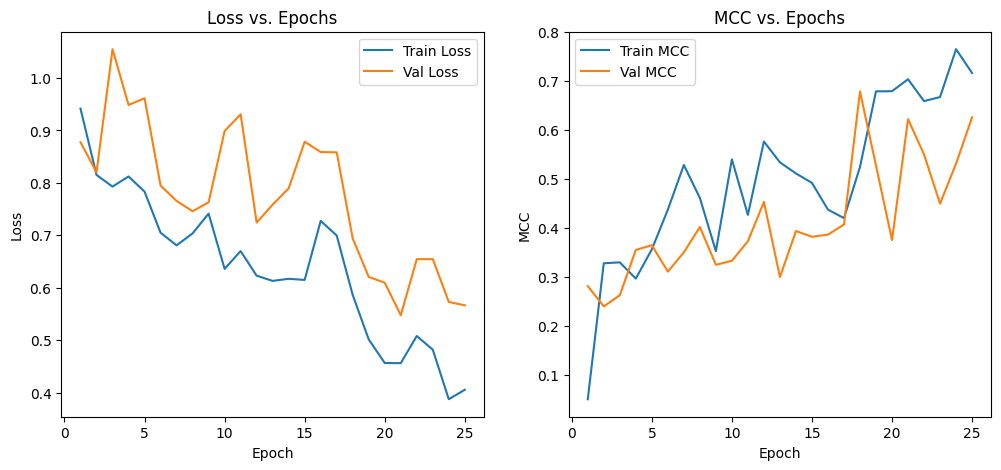

Accuracy: 0.8105
Precision: 0.7111
Recall: 0.8649
F1 Score: 0.7805
MCC: 0.6257
ROC AUC: 0.8886
PR AUC: 0.8537
Confusion Matrix:
[[45 13]
 [ 5 32]]


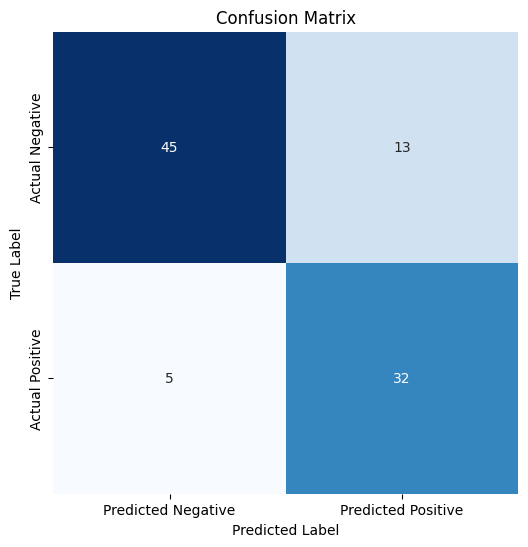

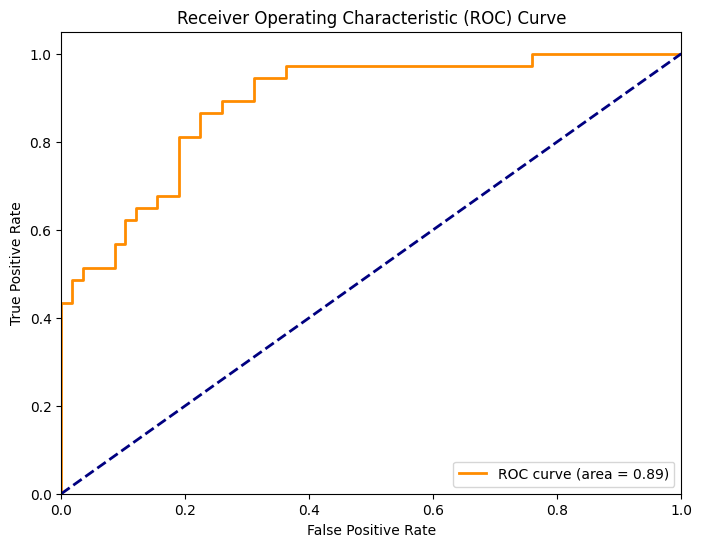

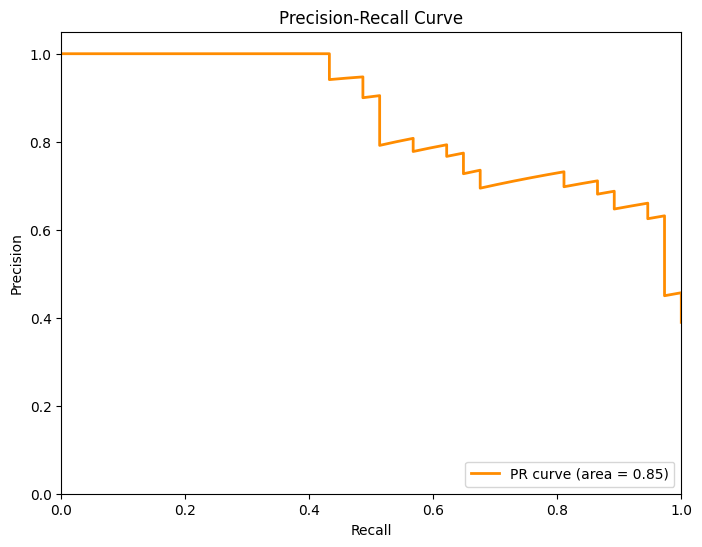

Parsing:  GCA_036903385
Parsing:  GCA_030073475
Parsing:  GCA_030068925
Parsing:  GCA_030068845
Parsing:  GCA_030068965
Parsing:  GCA_030069035
Parsing:  GCA_030069125
Parsing:  GCA_030068935
Parsing:  GCA_036903415
Parsing:  GCA_036903425
Parsing:  GCA_030068835
Parsing:  GCA_036903335
Parsing:  GCA_030068955
Parsing:  GCA_030069025
Parsing:  GCA_030069095
Parsing:  GCA_030069145
Parsing:  GCA_030069065
Parsing:  GCA_030073425
Parsing:  GCA_030068895
Parsing:  GCA_030069085
Parsing:  GCA_000006765
Parsing:  GCA_036903365
Parsing:  GCA_030068985
Parsing:  GCA_036903455
Loaded 24 embeddings from /content/drive/MyDrive/Arkin/ESM2/public_datasets/pseudomonas/strain_mod
Parsing:  ON857926
Parsing:  ON857936
Parsing:  ON857940
Parsing:  ON857937
Parsing:  ON857938
Parsing:  ON857930
Parsing:  ON857928
Parsing:  ON857931
Parsing:  ON857932
Parsing:  ON857927
Parsing:  ON857941
Parsing:  ON857934
Parsing:  ON857942
Parsing:  ON857939
Parsing:  ON857943
Parsing:  ON857935
Parsing:  ON857929
Pa

In [ ]:
if __name__ == "__main__":
    model, history, accuracy, precision, recall, f1, mcc, roc_auc, pr_auc, conf_matrix, all_preds, all_labels = main(debug=False)

    # Create a dictionary to store the outputs
    outputs = {
         'model': model,
         'history': history,
         'accuracy': accuracy,
         'precision': precision,
         'recall': recall,
         'f1': f1,
         'mcc': mcc,
         'roc_auc': roc_auc,
         'pr_auc': pr_auc,
         'conf_matrix': conf_matrix,
         'all_preds': all_preds,
         'all_labels': all_labels
    }

    # Get the directory of the interaction matrix
    output_dir = '/content/drive/MyDrive/Arkin/set_transformer_data/outputs'

    # Create a subdirectory for outputs if it doesn't exist
    output_subdir = os.path.join(output_dir, 'outputs')
    os.makedirs(output_subdir, exist_ok=True)

    # Construct the full file path for the output file
    output_file_path = os.path.join(output_subdir, 'main_function_outputs_pseudomonas_attention.pkl')  # or .joblib

    # Save the outputs
    with open(output_file_path, 'wb') as f:  # or 'wb' for joblib
        pickle.dump(outputs, f)  # or joblib.dump(outputs, f)

    # Need to make sure we also have access to these variables for attention analysis
    # strain_embeddings = load_embeddings('/content/drive/MyDrive/Arkin/set_transformer_data/embedding_sets/strains')
    # phage_embeddings  = load_embeddings('/content/drive/MyDrive/Arkin/set_transformer_data/embedding_sets/phages')
    strain_embeddings = load_embeddings('/content/drive/MyDrive/Arkin/ESM2/public_datasets/pseudomonas/strain_mod/')
    phage_embeddings  = load_embeddings('/content/drive/MyDrive/Arkin/ESM2/public_datasets/pseudomonas/phage_mod/')

    # 2. Load and split interactions
    interactions_df = pd.read_csv('/content/drive/MyDrive/Arkin/phage_public_datasets/pseudomonas/interaction_matrix.csv')
    # interactions_df = pd.read_csv('/content/drive/MyDrive/Arkin/set_transformer_data/EDGE_interaction_long_172_no2.csv')

    # Filter for available embeddings
    strain_keys = set(strain_embeddings.keys())
    phage_keys = set(phage_embeddings.keys())
    interactions_df = interactions_df[interactions_df['strain'].isin(strain_keys) &
                                    interactions_df['phage'].isin(phage_keys)]

    # Split data to get test_df
    _, test_df = filter_interactions_by_strain(interactions_df)

    # Create test_loader for attention analysis
    _, test_loader = create_data_loaders(
        None,
        test_df,
        strain_embeddings,
        phage_embeddings,
        batch_size=1  # Note: batch_size must be 1 for attention analysis
    )

    # Set output directory for attention analysis files
    attention_output_dir = os.path.join(output_dir, 'attention_analysis_pseudo')
    os.makedirs(attention_output_dir, exist_ok=True)

    print("Starting attention analysis...")

    # Run the attention analysis
    attention_results = export_attention_data(
        model=model,
        test_loader=test_loader,
        test_df=test_df,
        strain_embeddings=strain_embeddings,
        phage_embeddings=phage_embeddings,
        output_dir=attention_output_dir,
        num_samples=100,  # Adjust as needed
        device=device
    )

    print("Completed basic attention analysis. Starting pattern analysis...")

    # Run additional pattern analysis
    pattern_results = analyze_attention_patterns(
        important_genes_df=attention_results['important_genes_df'],
        output_dir=attention_output_dir
    )

    print(f"Attention analysis complete. Results saved to {attention_output_dir}")

    # Save attention results
    with open(os.path.join(attention_output_dir, 'attention_analysis_results_pseudo.pkl'), 'wb') as f:
        pickle.dump({
            'attention_results': attention_results,
            'pattern_results': pattern_results
        }, f)

## Attention Analysis

In [ ]:
def analyze_attention_variance(model, test_loader, device, num_samples=10):
    """Analyze the variance in attention weights to debug uniform attention issues"""
    model.eval()

    head_variances = []
    sample_variances = []

    with torch.no_grad():
        for i, (strain_emb, phage_emb, strain_mask, phage_mask, _) in enumerate(test_loader):
            if i >= num_samples:
                break

            strain_emb = strain_emb.to(device)
            phage_emb = phage_emb.to(device)
            strain_mask = strain_mask.to(device) if strain_mask is not None else None
            phage_mask = phage_mask.to(device) if phage_mask is not None else None

            # Get attention maps
            _, (strain_to_phage_attn, phage_to_strain_attn) = model(
                strain_emb, phage_emb, strain_mask, phage_mask, return_attn=True
            )

            # Convert to numpy for analysis
            strain_to_phage_attn = strain_to_phage_attn.cpu().numpy().squeeze(0)  # [num_heads, n_strain, n_phage]
            phage_to_strain_attn = phage_to_strain_attn.cpu().numpy().squeeze(0)  # [num_heads, n_phage, n_strain]

            # Analyze variance across different heads
            for head in range(strain_to_phage_attn.shape[0]):
                head_strain_variance = np.var(strain_to_phage_attn[head])
                head_phage_variance = np.var(phage_to_strain_attn[head])
                head_variances.append({
                    'sample': i,
                    'head': head,
                    'strain_to_phage_variance': head_strain_variance,
                    'phage_to_strain_variance': head_phage_variance
                })

            # Overall sample variance
            sample_strain_variance = np.var(strain_to_phage_attn)
            sample_phage_variance = np.var(phage_to_strain_attn)
            sample_variances.append({
                'sample': i,
                'strain_to_phage_variance': sample_strain_variance,
                'phage_to_strain_variance': sample_phage_variance
            })

    # Convert to DataFrames
    head_variance_df = pd.DataFrame(head_variances)
    sample_variance_df = pd.DataFrame(sample_variances)

    print("Average head variance:")
    print(head_variance_df[['strain_to_phage_variance', 'phage_to_strain_variance']].mean())

    print("\nAverage sample variance:")
    print(sample_variance_df[['strain_to_phage_variance', 'phage_to_strain_variance']].mean())

    return head_variance_df, sample_variance_df

def plot_variance_analysis(head_variance_df, sample_variance_df, output_dir):
    """Plot the variance analysis results"""
    os.makedirs(output_dir, exist_ok=True)

    # Plot head variance
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='head', y='strain_to_phage_variance', data=head_variance_df)
    plt.title('Strain-to-Phage Attention Variance by Head')
    plt.xlabel('Attention Head')
    plt.ylabel('Variance')
    plt.savefig(os.path.join(output_dir, 'strain_to_phage_head_variance.png'))
    plt.close()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='head', y='phage_to_strain_variance', data=head_variance_df)
    plt.title('Phage-to-Strain Attention Variance by Head')
    plt.xlabel('Attention Head')
    plt.ylabel('Variance')
    plt.savefig(os.path.join(output_dir, 'phage_to_strain_head_variance.png'))
    plt.close()

    # Plot sample variance
    plt.figure(figsize=(10, 6))
    plt.scatter(
        sample_variance_df['strain_to_phage_variance'],
        sample_variance_df['phage_to_strain_variance'],
        alpha=0.7
    )
    plt.xlabel('Strain-to-Phage Variance')
    plt.ylabel('Phage-to-Strain Variance')
    plt.title('Attention Variance by Sample')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(output_dir, 'sample_variance.png'))
    plt.close()

output_dir = '/content/drive/MyDrive/Arkin/set_transformer_data/outputs/attention_analysis/variance_analysis2'
os.makedirs(output_dir, exist_ok=True)

# Create a test loader with batch_size=1 for attention analysis
_, test_loader = create_data_loaders(
    None,
    test_df,
    strain_embeddings,
    phage_embeddings,
    batch_size=1  # Must be 1 for attention analysis
)

# Run the variance analysis
head_variance_df, sample_variance_df = analyze_attention_variance(
    model, test_loader, device, num_samples=20
)

# Plot and save the results
plot_variance_analysis(head_variance_df, sample_variance_df, output_dir)

## Model Performance

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import random
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from torch.utils.data import Dataset, DataLoader

def load_embeddings(embedding_dir: str) -> Dict[str, np.ndarray]:
    """Load all embeddings from a directory (.npy files)."""
    embedding_dir = Path(embedding_dir)
    embeddings = {}

    for file_path in embedding_dir.glob('*.npy'):
        identifier = file_path.stem  # filename without extension
        print('Parsing: ', identifier)
        embedding = np.load(file_path)
        embeddings[identifier] = embedding

    print(f"Loaded {len(embeddings)} embeddings from {embedding_dir}")
    return embeddings

def filter_interactions_by_strain(interactions_df: pd.DataFrame,
                                random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Split interactions into train/test by strain."""
    unique_strains = interactions_df['strain'].unique()
    train_strains, test_strains = train_test_split(
        unique_strains,
        test_size=0.2,
        random_state=random_state
    )

    train_df = interactions_df[interactions_df['strain'].isin(train_strains)]
    test_df = interactions_df[interactions_df['strain'].isin(test_strains)]

    print(f"Train set: {len(train_df)} interactions, {len(train_strains)} strains")
    print(f"Test set:  {len(test_df)} interactions, {len(test_strains)} strains")
    return train_df, test_df

class StrainPhageDataset(Dataset):
    def __init__(self,
                 interactions_df: pd.DataFrame,
                 strain_embeddings: Dict[str, np.ndarray],
                 phage_embeddings: Dict[str, np.ndarray]):
        self.interactions = interactions_df.reset_index(drop=True)
        self.strain_embeddings = strain_embeddings
        self.phage_embeddings = phage_embeddings

        # Check for missing embeddings
        missing_strains = set(self.interactions['strain']) - set(strain_embeddings.keys())
        missing_phages = set(self.interactions['phage']) - set(phage_embeddings.keys())

        if missing_strains or missing_phages:
            raise ValueError(
                f"Missing embeddings for {len(missing_strains)} strains "
                f"and {len(missing_phages)} phages."
            )

    def __len__(self):
        return len(self.interactions)

    def __getitem__(self, idx):
        row = self.interactions.iloc[idx]
        strain_emb = torch.tensor(
            self.strain_embeddings[row['strain']], dtype=torch.float32
        )
        phage_emb = torch.tensor(
            self.phage_embeddings[row['phage']], dtype=torch.float32
        )
        label = torch.tensor(row['interaction'], dtype=torch.float32)
        return strain_emb, phage_emb, label

def collate_variable_sets(batch):
    """Collate function for variable length sets."""
    strains, phages, labels = zip(*batch)

    max_strain_len = max(s.shape[0] for s in strains)
    max_phage_len = max(p.shape[0] for p in phages)
    emb_dim = strains[0].shape[1]
    batch_size = len(batch)

    strain_padded = torch.zeros(batch_size, max_strain_len, emb_dim, dtype=torch.float32)
    phage_padded = torch.zeros(batch_size, max_phage_len, emb_dim, dtype=torch.float32)
    strain_mask = torch.zeros(batch_size, max_strain_len, dtype=torch.bool)
    phage_mask = torch.zeros(batch_size, max_phage_len, dtype=torch.bool)
    label_batch = torch.zeros(batch_size, 1, dtype=torch.float32)

    for i, (s_emb, p_emb, label) in enumerate(batch):
        s_len = s_emb.shape[0]
        p_len = p_emb.shape[0]

        strain_padded[i, :s_len, :] = s_emb
        phage_padded[i, :p_len, :] = p_emb
        strain_mask[i, :s_len] = True
        phage_mask[i, :p_len] = True
        label_batch[i, 0] = float(label)

    return strain_padded, phage_padded, strain_mask, phage_mask, label_batch

def create_data_loaders(train_df: Optional[pd.DataFrame],
                       test_df: pd.DataFrame,
                       strain_embeddings: Dict[str, np.ndarray],
                       phage_embeddings: Dict[str, np.ndarray],
                       batch_size: int = 1) -> Tuple[DataLoader, DataLoader]:
    """Create data loaders for training and testing."""
    train_loader = None
    if train_df is not None and not train_df.empty:
        train_dataset = StrainPhageDataset(train_df, strain_embeddings, phage_embeddings)
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True,
            collate_fn=collate_variable_sets
        )

    test_dataset = StrainPhageDataset(test_df, strain_embeddings, phage_embeddings)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        collate_fn=collate_variable_sets
    )

    return train_loader, test_loader

class AttentionVisualizer:
    """Tools for visualizing attention patterns in the strain-phage transformer."""

    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()

    def get_attention_maps(self,
                         strain_emb: torch.Tensor,
                         phage_emb: torch.Tensor,
                         strain_mask: Optional[torch.Tensor] = None,
                         phage_mask: Optional[torch.Tensor] = None) -> Tuple[np.ndarray, np.ndarray]:
        with torch.no_grad():
            _, (strain_attn, phage_attn) = self.model(
                strain_emb.to(self.device),
                phage_emb.to(self.device),
                strain_mask.to(self.device) if strain_mask is not None else None,
                phage_mask.to(self.device) if phage_mask is not None else None,
                return_attn=True
            )

            strain_to_phage_attn = strain_attn.cpu().numpy().squeeze(0)
            phage_to_strain_attn = phage_attn.cpu().numpy().squeeze(0)

            return strain_to_phage_attn, phage_to_strain_attn

    def plot_attention_heatmap(self,
                             attention_matrix: np.ndarray,
                             head_idx: int,
                             x_labels: List[str],
                             y_labels: List[str],
                             title: str = "Attention Weights",
                             figsize: Tuple[int, int] = (10, 8)):
        attn_weights = attention_matrix[head_idx]
        plt.figure(figsize=figsize)
        sns.heatmap(attn_weights,
                   xticklabels=x_labels,
                   yticklabels=y_labels,
                   cmap='viridis',
                   cbar_kws={'label': 'Attention Weight'})
        plt.title(f"{title} (Head {head_idx})")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def plot_aggregated_attention(self,
                                attention_matrix: np.ndarray,
                                x_labels: List[str],
                                y_labels: List[str],
                                aggregation: str = 'mean',
                                title: str = "Aggregated Attention Weights",
                                figsize: Tuple[int, int] = (10, 8)):
        if aggregation == 'mean':
            attn_weights = attention_matrix.mean(axis=0)
        elif aggregation == 'max':
            attn_weights = attention_matrix.max(axis=0)
        else:
            raise ValueError("aggregation must be 'mean' or 'max'")

        plt.figure(figsize=figsize)
        sns.heatmap(attn_weights,
                   xticklabels=x_labels,
                   yticklabels=y_labels,
                   cmap='viridis',
                   cbar_kws={'label': 'Attention Weight'})
        plt.title(f"{title} ({aggregation} across heads)")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def plot_attention_patterns(self,
                              strain_emb: torch.Tensor,
                              phage_emb: torch.Tensor,
                              strain_genes: List[str],
                              phage_genes: List[str],
                              strain_mask: Optional[torch.Tensor] = None,
                              phage_mask: Optional[torch.Tensor] = None):
        strain_to_phage_attn, phage_to_strain_attn = self.get_attention_maps(
            strain_emb, phage_emb, strain_mask, phage_mask
        )

        n_heads = strain_to_phage_attn.shape[0]

        for head in range(n_heads):
            self.plot_attention_heatmap(
                strain_to_phage_attn,
                head,
                phage_genes,
                strain_genes,
                title="Strain-to-Phage Attention"
            )

        for head in range(n_heads):
            self.plot_attention_heatmap(
                phage_to_strain_attn,
                head,
                strain_genes,
                phage_genes,
                title="Phage-to-Strain Attention"
            )

        self.plot_aggregated_attention(
            strain_to_phage_attn,
            phage_genes,
            strain_genes,
            title="Aggregated Strain-to-Phage Attention"
        )

        self.plot_aggregated_attention(
            phage_to_strain_attn,
            strain_genes,
            phage_genes,
            title="Aggregated Phage-to-Strain Attention"
        )

    def analyze_important_genes(self,
                              attention_matrix: np.ndarray,
                              gene_names: List[str],
                              top_k: int = 5,
                              aggregation: str = 'mean') -> List[Tuple[str, float]]:
        if aggregation == 'mean':
            scores = attention_matrix.mean(axis=(0, 1))
        elif aggregation == 'max':
            scores = attention_matrix.max(axis=(0, 1))
        else:
            raise ValueError("aggregation must be 'mean' or 'max'")

        top_indices = np.argsort(scores)[-top_k:][::-1]
        top_genes = [(gene_names[i], scores[i]) for i in top_indices]
        return top_genes

def load_and_analyze_attention(
    output_path: str,
    data_dir: str,
    device: str = 'cuda',
    num_samples: int = 5,
    debug: bool = False
):
    """Load saved model and perform attention analysis."""
    print(f"Loading outputs from {output_path}")
    with open(output_path, 'rb') as f:
        outputs = pickle.load(f)

    model = outputs['model']
    model = model.to(device)
    model.eval()

    print("Loading embeddings...")
    strain_embeddings = load_embeddings(os.path.join(data_dir, 'embedding_sets/strains/'))
    phage_embeddings = load_embeddings(os.path.join(data_dir, 'embedding_sets/phages/'))

    print("Loading interaction data...")
    interactions_df = pd.read_csv(os.path.join(data_dir, 'EDGE_interaction_long_172_no2.csv'))

    # Filter interactions_df before splitting
    strain_keys = set(strain_embeddings.keys())
    phage_keys = set(phage_embeddings.keys())
    interactions_df = interactions_df[
        interactions_df['strain'].isin(strain_keys) &
        interactions_df['phage'].isin(phage_keys)
    ]

    if debug:
        print("Running in debug mode with reduced dataset...")
        random_strains = random.sample(list(strain_keys), 50)
        random_phages = random.sample(list(phage_keys), 50)
        interactions_df = interactions_df[
            interactions_df['strain'].isin(random_strains) &
            interactions_df['phage'].isin(random_phages)
        ]

    print("Splitting data...")
    train_df, test_df = filter_interactions_by_strain(interactions_df)

    print("Creating data loader...")
    _, test_loader = create_data_loaders(
        None, test_df, strain_embeddings, phage_embeddings, batch_size=1
    )

    visualizer = AttentionVisualizer(model, device)

    print(f"\nAnalyzing {num_samples} samples...")
    for i, (strain_emb, phage_emb, strain_mask, phage_mask, label) in enumerate(test_loader):
        if i >= num_samples:
            break

        print(f"\nAnalyzing sample {i+1} (Label: {label.item():.0f})")
        sample_strain = test_df.iloc[i]['strain']
        sample_phage = test_df.iloc[i]['phage']
        print(f"Strain: {sample_strain}, Phage: {sample_phage}")

        strain_to_phage_attn, phage_to_strain_attn = visualizer.get_attention_maps(
            strain_emb, phage_emb, strain_mask, phage_mask
        )

        print("\nPlotting attention patterns...")
        # Continuing from where we left off...
        strain_genes = [f"{sample_strain}_gene_{j}" for j in range(len(strain_embeddings[sample_strain]))]
        phage_genes = [f"{sample_phage}_gene_{j}" for j in range(len(phage_embeddings[sample_phage]))]

        visualizer.plot_attention_patterns(
            strain_emb,
            phage_emb,
            strain_genes,
            phage_genes,
            strain_mask,
            phage_mask
        )

        print("\nAnalyzing important genes...")
        top_phage_genes = visualizer.analyze_important_genes(
            strain_to_phage_attn,
            phage_genes,
            top_k=5
        )
        print("Most attended-to phage genes:")
        for gene, score in top_phage_genes:
            print(f"{gene}: {score:.3f}")

        top_strain_genes = visualizer.analyze_important_genes(
            phage_to_strain_attn,
            strain_genes,
            top_k=5
        )
        print("\nMost attended-to strain genes:")
        for gene, score in top_strain_genes:
            print(f"{gene}: {score:.3f}")

        print("\n" + "="*50)

if __name__ == "__main__":
    # Import required for train_test_split
    from sklearn.model_selection import train_test_split

    # Set paths
    data_dir = '/content/drive/MyDrive/Arkin/set_transformer_data'
    output_path = os.path.join(data_dir, 'outputs/outputs/main_function_outputs_ecoli_1024_5_2layer.pkl')

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Run analysis
    load_and_analyze_attention(
        output_path=output_path,
        data_dir=data_dir,
        device=device,
        num_samples=5,  # Adjust this number to analyze more or fewer samples
        debug=False     # Set to True to run with reduced dataset
    )